In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/BXT/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/BXT


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import math
import random

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
torch.set_default_dtype(torch.float64)

Using device: cuda


In [4]:
# def set_seed(seed=63):
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     os.environ['PYTHONHASHSEED'] = str(seed)

# set_seed(2025)

In [5]:
class SourceTargetDataset(Dataset):
    """
    A dataset that loads all data into GPU memory during initialization.
    This is highly efficient for small datasets.
    """
    def __init__(self, source_csv_path, target_csv_path, size=512):
        # 1. Load data from CSV using pandas (remains on CPU for now)
        feature_dtypes = {f'dim_{i}': np.float64 for i in range(size * 2)}
        feature_dtypes['label'] = np.int64

        source_df = pd.read_csv(source_csv_path, dtype=feature_dtypes)
        target_df = pd.read_csv(target_csv_path, dtype={f'dim{i}': np.float64 for i in range(size * 2)})

        feature_cols = [f'dim_{i}' for i in range(size * 2)]

        # 2. Convert to NumPy arrays
        source_features_np = source_df[feature_cols].values
        source_labels_np = source_df['label'].values
        target_features_np = target_df[feature_cols].values

        # 3. The key change: Convert to PyTorch tensors and move to GPU *once*
        self.source_features = torch.tensor(source_features_np, dtype=torch.float64).to(device)
        self.source_labels = torch.tensor(source_labels_np, dtype=torch.long).to(device)
        self.target_features = torch.tensor(target_features_np, dtype=torch.float64).to(device)

        self.length = min(len(self.source_features), len(self.target_features))
        print(f"Loaded {self.length} samples directly to device '{device}'")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Data is already on the GPU, so this is just fast tensor indexing
        return {
            'source_features': self.source_features[idx],
            'source_label': self.source_labels[idx],
            'target_features': self.target_features[idx]
        }


def get_data_loader(source_csv_path, target_csv_path, size=512, batch_size=32, shuffle=True, num_workers=0):
    dataset = SourceTargetDataset(source_csv_path, target_csv_path, size=size)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,      # Must be 0 when using tensors directly from the parent process's GPU
        pin_memory=False    # Irrelevant as data is already on the GPU
    )
    return loader

In [6]:
class DomainAdaptationDataset(Dataset):
    """
    A dataset that loads data from a single CSV, splits it into source and
    target domains based on an 'event_name' column, and moves all data to the
    specified device (e.g., GPU) during initialization.

    This is highly efficient for datasets that can fit entirely in GPU memory.
    """
    def __init__(self, csv_path, source_event_name, target_event_name, feature_dim=1536, label_col='label'):
        """
        Args:
            csv_path (str): Path to the single CSV file.
            source_event_name (str): The value in the 'event_name' column for source data.
            target_event_name (str): The value in the 'event_name' column for target data.
            feature_dim (int): The number of feature columns (e.g., 1536 for dim_0 to dim_1535).
            label_col (str): The name of the column containing the labels.
        """
        # 1. Define column names and dtypes for efficient loading
        feature_cols = [f'dim_{i}' for i in range(feature_dim)]

        # Define dtypes to reduce memory usage during pandas loading
        dtypes = {col: np.float64 for col in feature_cols}
        dtypes[label_col] = np.int64
        dtypes['event_name'] = str

        # 2. Load the entire CSV using pandas
        print(f"Loading data from {csv_path}...")
        full_df = pd.read_csv(csv_path, dtype=dtypes)
        print("Data loaded into memory. Filtering by event_name...")

        # 3. Filter DataFrame to create source and target domains
        source_df = full_df[full_df['event_name'] == source_event_name].reset_index(drop=True)
        target_df = full_df[full_df['event_name'] == target_event_name].reset_index(drop=True)

        if len(source_df) == 0:
            raise ValueError(f"No data found for source_event_name='{source_event_name}'")
        if len(target_df) == 0:
            raise ValueError(f"No data found for target_event_name='{target_event_name}'")

        print(f"Found {len(source_df)} source samples and {len(target_df)} target samples.")

        # 4. Convert filtered data to NumPy arrays
        source_features_np = source_df[feature_cols].values
        source_labels_np = source_df[label_col].values
        target_features_np = target_df[feature_cols].values
        target_labels_np = target_df[label_col].values # Also get labels for target

        # 5. The key step: Convert to PyTorch tensors and move to the device *once*
        self.source_features = torch.tensor(source_features_np, dtype=torch.float64).to(device)
        self.source_labels = torch.tensor(source_labels_np, dtype=torch.long).to(device)
        self.target_features = torch.tensor(target_features_np, dtype=torch.float64).to(device)
        self.target_labels = torch.tensor(target_labels_np, dtype=torch.long).to(device)

        # The dataset length is the minimum of the two domains to ensure we can always pair samples
        self.length = min(len(self.source_features), len(self.target_features))
        print(f"Dataset initialized. Length set to {self.length} (minimum of source/target). Data is on device '{device}'.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # Data is already on the device, so this is just fast tensor indexing.
        # Note: If shuffle=True in DataLoader, the indices 'idx' will be shuffled.
        # This implementation pairs the i-th source sample with the i-th target sample
        # from their respective (shuffled) lists.
        return {
            'source_features': self.source_features[idx],
            'source_label':    self.source_labels[idx],
            'target_features': self.target_features[idx],
            'target_label':    self.target_labels[idx] # Return target label for evaluation
        }

def get_domain_adaptation_loader(csv_path, source_event_name, target_event_name, feature_dim=1536, batch_size=32, shuffle=True):
    """
    Creates and returns a DataLoader for domain adaptation.

    Args:
        csv_path (str): Path to the single CSV file.
        source_event_name (str): The event name for the source domain.
        target_event_name (str): The event name for the target domain.
        feature_dim (int): The number of feature dimensions.
        batch_size (int): The size of each batch.
        shuffle (bool): Whether to shuffle the data at each epoch.

    Returns:
        A PyTorch DataLoader instance.
    """
    dataset = DomainAdaptationDataset(
        csv_path=csv_path,
        source_event_name=source_event_name,
        target_event_name=target_event_name,
        feature_dim=feature_dim
    )

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0,      # MUST be 0 when data is on CUDA in the main process
        pin_memory=False    # Irrelevant as data is already on the target device
    )
    return loader

In [7]:
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

class GradientReversalLayer(nn.Module):
    def __init__(self, lambda_=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

class FeatureExtractor(nn.Module):
    def __init__(self, input_size):
        super(FeatureExtractor, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, 768),
            nn.LeakyReLU(0.2),
            nn.Linear(768, 512),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.model(x)

# BlueSky + CrisisMMD
# class FeatureExtractor(nn.Module):
#     def __init__(self, input_size, num_heads=8):
#         """
#         input_size: total feature dim (e.g. 1536)
#         Assumes two tokens of size input_size//2 each.
#         """
#         super(FeatureExtractor, self).__init__()
#         assert input_size % 2 == 0, "input_size must be divisible by 2"
#         self.token_dim = input_size // 2

#         # Cross‑attention on the two tokens
#         self.attention = nn.MultiheadAttention(
#             embed_dim=self.token_dim,
#             num_heads=num_heads,
#             batch_first=True
#         )

#         self.model = nn.Sequential(
#             nn.Linear(input_size, 768),
#             nn.LeakyReLU(0.2),
#             nn.Linear(768, 512),
#             nn.LeakyReLU(0.2)
#         )

#     def forward(self, x):
#         token1 = x[:, :self.token_dim]
#         token2 = x[:, self.token_dim:]
#         tokens = torch.stack([token1, token2], dim=1)

#         attn_output, _ = self.attention(tokens, tokens, tokens)
#         attended = attn_output.reshape(x.size(0), -1)

#         return self.model(attended)

class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            GradientReversalLayer(),
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

In [8]:
def plot_tsne(feature_extractor, dataset, device, num_points=2000, title="t-SNE Visualization"):
    """
    Generates and displays a t-SNE plot for features from source and target domains.

    Args:
        feature_extractor (nn.Module): The trained feature extractor model (G).
        dataset (SourceTargetDataset): The dataset object containing source and target data.
        device (torch.device): The device the data and models are on.
        num_points (int): The number of points to sample from EACH domain (total points = 2 * num_points).
        title (str): The title for the plot.
    """
    print(f"\nGenerating t-SNE plot with {num_points} points from each domain (total {num_points*2})...")

    # Set the model to evaluation mode
    feature_extractor.eval()

    # Ensure we don't sample more points than available
    num_source_samples = min(num_points, len(dataset.source_features))
    num_target_samples = min(num_points, len(dataset.target_features))

    # Generate random indices for sampling
    source_indices = torch.randperm(len(dataset.source_features), device=device)[:num_source_samples]
    target_indices = torch.randperm(len(dataset.target_features), device=device)[:num_target_samples]

    # Sample data from the dataset (which is already on the GPU)
    source_data_sample = dataset.source_features[source_indices]
    target_data_sample = dataset.target_features[target_indices]

    # Generate embeddings using the feature extractor
    with torch.no_grad():
        source_embeddings = feature_extractor(source_data_sample)
        target_embeddings = feature_extractor(target_data_sample)

    # Move embeddings to CPU for scikit-learn
    source_cpu = source_embeddings.cpu().numpy()
    target_cpu = target_embeddings.cpu().numpy()

    # Combine embeddings from both domains
    combined_embeddings = np.vstack((source_cpu, target_cpu))

    # Create labels to distinguish domains (0 for source, 1 for target)
    source_domain_labels = np.zeros(num_source_samples)
    target_domain_labels = np.ones(num_target_samples)
    combined_labels = np.concatenate((source_domain_labels, target_domain_labels))

    # Perform t-SNE
    print("Running t-SNE... This may take a moment.")
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300, random_state=42)
    tsne_results = tsne.fit_transform(combined_embeddings)

    # Plot the results
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=combined_labels, cmap='coolwarm', alpha=0.7, s=15)
    plt.title(title, fontsize=16)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)

    # Create a clear legend
    handles, _ = scatter.legend_elements()
    plt.legend(handles, ['Source Domain', 'Target Domain'], title="Domain", fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # Set the model back to train mode for any further use
    feature_extractor.train()

In [9]:
def plot_confusion_matrix(cm, title):
    """Helper function to create a visual confusion matrix using seaborn."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d', # format as integer
        cmap='Blues',
        xticklabels=['Predicted 0 (Neg)', 'Predicted 1 (Pos)'],
        yticklabels=['Actual 0 (Neg)', 'Actual 1 (Pos)']
    )
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    """
    Calculates and plots the ROC curve and prints the AUC score.

    Args:
        y_true (np.array): True binary labels.
        y_scores (np.array): Target scores, can either be probability estimates of the
                             positive class or confidence values.
        title (str): The title for the plot.

    Returns:
        float: The calculated Area Under the Curve (AUC).
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

    return roc_auc # Return the AUC score for printing

def test_model_on_new_file(G, C, test_csv_path, source_event_name, target_event_name, feature_dim=1536, label_col='label'):
    """
    Loads data from a new test CSV, evaluates the trained models (G and C) on it,
    and prints detailed metrics, confusion matrices, and ROC curves.
    """
    print("\n--- Starting Final Evaluation on Test File ---")
    print(f"Loading test data from: {test_csv_path}")

    # 1. Load and process the new CSV data
    feature_cols = [f'dim_{i}' for i in range(feature_dim)]
    dtypes = {col: np.float64 for col in feature_cols}
    dtypes[label_col] = np.int64
    dtypes['event_name'] = str
    test_df = pd.read_csv(test_csv_path, dtype=dtypes)

    source_df = test_df[test_df['event_name'] == source_event_name]
    target_df = test_df[test_df['event_name'] == target_event_name]

    if len(source_df) == 0 or len(target_df) == 0:
        print("Warning: No data found for one or both event names in the test file.")
        return

    print(f"Found {len(source_df)} source and {len(target_df)} target samples in the test file.")

    # Convert to Tensors and move to device
    source_features = torch.tensor(source_df[feature_cols].values, dtype=torch.float64).to(device)
    source_labels = torch.tensor(source_df[label_col].values, dtype=torch.long).to(device)
    target_features = torch.tensor(target_df[feature_cols].values, dtype=torch.float64).to(device)
    target_labels = torch.tensor(target_df[label_col].values, dtype=torch.long).to(device)

    # 2. Perform inference
    G.eval()
    C.eval()
    with torch.no_grad():
        # Source domain
        source_feats_extracted = G(source_features)
        source_outputs = C(source_feats_extracted)
        source_probs = F.softmax(source_outputs, dim=1)[:, 1] # Get probs for class 1
        _, source_predicted = torch.max(source_outputs.data, 1)

        # Target domain
        target_feats_extracted = G(target_features)
        target_outputs = C(target_feats_extracted)
        target_probs = F.softmax(target_outputs, dim=1)[:, 1] # Get probs for class 1
        _, target_predicted = torch.max(target_outputs.data, 1)

        # Move all results to CPU for sklearn
        all_source_preds = source_predicted.cpu().numpy()
        all_source_labels = source_labels.cpu().numpy()
        all_source_scores = source_probs.cpu().numpy()

        all_target_preds = target_predicted.cpu().numpy()
        all_target_labels = target_labels.cpu().numpy()
        all_target_scores = target_probs.cpu().numpy()

    # 3. Calculate and display metrics
    def print_final_metrics(domain_name, y_true, y_pred, y_scores):
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        print(f"\n--- Final Test Metrics: {domain_name} Domain ---")
        print(f"Accuracy:                {accuracy:.4f}")
        print(f"Precision (for class 1): {precision:.4f}")
        print(f"Recall (for class 1):    {recall:.4f}")
        print(f"F1-Score (for class 1):  {f1:.4f}")

        # Plot ROC curve and get AUC
        roc_auc = plot_roc_curve(y_true, y_scores, title=f'Final Test - {domain_name} ROC Curve')
        print(f"AUC-ROC:                 {roc_auc:.4f}")

        # Plot confusion matrix
        plot_confusion_matrix(cm, title=f'Final Test - {domain_name} Confusion Matrix')

    print_final_metrics("Source", all_source_labels, all_source_preds, all_source_scores)
    print_final_metrics("Target", all_target_labels, all_target_preds, all_target_scores)
    print("\n--- Final Evaluation Complete ---")


def evaluate_domain_performance(G, C, test_csv_path, domain_name, feature_dim=1536, label_col='label'):
    """
    Loads data from a test CSV and evaluates the models, ensuring data is float64.
    """
    print(f"\n--- Evaluating: {domain_name} Domain ---")
    print(f"Loading data from: {test_csv_path}")

    # 1. Load and process the data
    feature_cols = [f'dim_{i}' for i in range(feature_dim)]
    try:
        test_df = pd.read_csv(test_csv_path)
    except FileNotFoundError:
        print(f"Error: The file was not found at {test_csv_path}")
        return

    # CORRECTED LINE: Ensure the dtype is torch.float64 to match your model's weights.
    features = torch.tensor(test_df[feature_cols].values, dtype=torch.float64).to(device)
    # Alternatively, you could just let it use the default you set:
    # features = torch.tensor(test_df[feature_cols].values).to(device)

    labels = torch.tensor(test_df[label_col].values, dtype=torch.long).to(device)

    # 2. Perform inference
    G.eval()
    C.eval()
    with torch.no_grad():
        # This call will now work with your float64 model
        extracted_features = G(features)
        outputs = C(extracted_features)
        probs = F.softmax(outputs, dim=1)[:, 1]
        _, predicted = torch.max(outputs.data, 1)

        # Move results to CPU for sklearn
        all_preds = predicted.cpu().numpy()
        all_labels = labels.cpu().numpy()
        all_scores = probs.cpu().numpy()

    # 3. Calculate and display metrics (This part remains the same)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, pos_label=1, zero_division=0)
    recall = recall_score(all_labels, all_preds, pos_label=1, zero_division=0)
    f1 = f1_score(all_labels, all_preds, pos_label=1, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
    roc_auc = roc_auc_score(all_labels, all_scores)

    print(f"\n** Test Metrics for {domain_name} Domain **")
    print(f"Accuracy:                {accuracy:.4f}")
    print(f"Precision (for class 1): {precision:.4f}")
    print(f"Recall (for class 1):    {recall:.4f}")
    print(f"F1-Score (for class 1):  {f1:.4f}")
    print(f"AUC-ROC:                 {roc_auc:.4f}")

    # 4. Plotting
    plot_roc_curve(all_labels, all_scores, title=f'Test - {domain_name} ROC Curve')
    plot_confusion_matrix(cm, title=f'Test - {domain_name} Confusion Matrix')


In [10]:
class DomainAdaptation():

    def __init__(self, source_path, target_path, num_classes, size = 512, batch_size=16, epochs = 20, csv_path = None):


        # self.dataloader = get_domain_adaptation_loader(
        #     csv_path=csv_path,
        #     source_event_name=source_path,
        #     target_event_name=target_path,
        #     feature_dim=size*2,
        #     batch_size=batch_size
        # )

        self.dataloader = get_data_loader(source_path, target_path, size = size, batch_size=batch_size)
        self.num_classes = num_classes

        self.G = FeatureExtractor(input_size=size*2).to(device)               # Generator
        self.C = Classifier(input_size=512, num_classes=self.num_classes).to(device)   # Classifier
        self.C1 = Classifier(input_size=512, num_classes=self.num_classes).to(device)  # Classifier-1
        self.C2 = Classifier(input_size=512, num_classes=self.num_classes).to(device)  # Classifier-2
        self.D = Discriminator(input_size=512).to(device)                   # Discriminator

        self.batch_size = batch_size
        self.lr = 5e-4
        self.epochs = epochs

        self.set_optimizer()                # Setting Up Adam Optimizer
        self.reset_grad()

        # Saving Pseudo-Labels of Target Domain Batch
        self.output_cr_t_C_label = np.zeros(self.batch_size)


    def set_optimizer(self):
        self.opt_g = optim.Adam(self.G.parameters(), lr=self.lr)
        self.opt_c = optim.Adam(self.C.parameters(), lr=self.lr)
        self.opt_c1 = optim.Adam(self.C1.parameters(), lr=self.lr)
        self.opt_c2 = optim.Adam(self.C2.parameters(), lr=self.lr)
        self.opt_d = optim.Adam(self.D.parameters(), lr=self.lr)


    def reset_grad(self):
        self.opt_g.zero_grad()
        self.opt_c.zero_grad()
        self.opt_c1.zero_grad()
        self.opt_c2.zero_grad()
        self.opt_d.zero_grad()


    def discrepancy(self, out1, out2):
        return torch.mean(torch.abs(F.softmax(out1, dim=1) - F.softmax(out2, dim=1)))


    def linear_mmd(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X - f_of_Y
        loss = torch.mean(torch.mm(delta, torch.transpose(delta, 0, 1)))
        return loss


    def ent(self, output):
        return -torch.mean(F.softmax(output, dim=1) * F.log_softmax(output, dim=1))

    def test_target_domain(self, epoch):
        """
        Evaluates the model on the target domain using the main classifier C.
        This is a quick check and doesn't show all metrics.
        """
        self.G.eval()
        self.C.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for batch in self.dataloader:
                target_features = batch['target_features'].to(device)
                target_labels = batch['target_label'].to(device)
                features = self.G(target_features)
                outputs = self.C(features)
                _, predicted = torch.max(outputs.data, 1)
                total_samples += target_labels.size(0)
                total_correct += (predicted == target_labels).sum().item()
        accuracy = 100 * total_correct / total_samples
        print(f"\n--- Quick Epoch {epoch} Target Accuracy ---")
        print(f"Accuracy: {accuracy:.2f}% ({total_correct}/{total_samples})")
        print("---------------------------------------\n")
        self.G.train()
        self.C.train()

    def evaluate_and_print_metrics(self, epoch):
        """
        Performs a full evaluation on the entire source and target sets during training.
        """
        self.G.eval()
        self.C.eval()

        source_features = self.dataloader.dataset.source_features
        source_labels = self.dataloader.dataset.source_labels
        target_features = self.dataloader.dataset.target_features
        target_labels = self.dataloader.dataset.target_labels

        with torch.no_grad():
            # Source domain inference
            source_feats_extracted = self.G(source_features)
            source_outputs = self.C(source_feats_extracted)
            source_probs = F.softmax(source_outputs, dim=1)[:, 1]
            _, source_predicted = torch.max(source_outputs.data, 1)

            # Target domain inference
            target_feats_extracted = self.G(target_features)
            target_outputs = self.C(target_feats_extracted)
            target_probs = F.softmax(target_outputs, dim=1)[:, 1]
            _, target_predicted = torch.max(target_outputs.data, 1)

            # Move results to CPU for sklearn
            all_source_preds = source_predicted.cpu().numpy()
            all_source_labels = source_labels.cpu().numpy()
            all_source_scores = source_probs.cpu().numpy()

            all_target_preds = target_predicted.cpu().numpy()
            all_target_labels = target_labels.cpu().numpy()
            all_target_scores = target_probs.cpu().numpy()

        print(f"\n--- Full Epoch {epoch} Evaluation ---")

        def print_metrics(domain_name, y_true, y_pred, y_scores):
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
            recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
            f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
            cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

            print(f"--- {domain_name} Domain Metrics ---")
            print(f"Accuracy:                {accuracy:.4f}")
            print(f"Precision (for class 1): {precision:.4f}")
            print(f"Recall (for class 1):    {recall:.4f}")
            print(f"F1-Score (for class 1):  {f1:.4f}")

            # Plot ROC and get AUC
            roc_auc = plot_roc_curve(y_true, y_scores, title=f'Epoch {epoch} - {domain_name} ROC Curve')
            print(f"AUC-ROC:                 {roc_auc:.4f}")

            # Plot confusion matrix
            plot_confusion_matrix(cm, title=f'Epoch {epoch} - {domain_name} Confusion Matrix')


        print_metrics("Source", all_source_labels, all_source_preds, all_source_scores)
        print_metrics("Target", all_target_labels, all_target_preds, all_target_scores)
        print("--------------------------------\n")

        self.G.train()
        self.C.train()



    def train(self):
        A_st_min = 0.0
        A_st_max = 0.0
        min_J_w = 1.0
        max_J_w = 1.0
        A_st_norm = 0.5
        J_w_norm = 0.5

        # Switched to CrossEntropyLoss for multi-class classification
        criterion = nn.CrossEntropyLoss()
        discriminator_criterion = nn.CrossEntropyLoss()

        for epoch in range(self.epochs):
            self.G.train()
            self.C.train()
            self.C1.train()
            self.C2.train()
            self.D.train()
            fea_for_LDA = np.empty(shape=(0, 512))
            fea_s_for_LDA = np.empty(shape=(0, 512))
            label_for_LDA = np.empty(shape=(0, 1))
            label_s_for_LDA = []

            # Training loop
            for batch_idx, batch in enumerate(tqdm(self.dataloader, desc=f"Epoch {epoch+1}/{self.epochs}")):
                source_features = batch['source_features']
                # Ensure labels are of type Long for CrossEntropyLoss
                source_labels = batch['source_label']
                target_features = batch['target_features']

                actual_batch_size = source_features.size(0)
                if actual_batch_size != self.batch_size:
                    continue

                self.reset_grad()

                # T_complex = A_st_norm /(A_st_norm + (1.0 - J_w_norm))
                # T = T_complex.real
                T = 0.3

                # Normal Supervised Learning on Source Domain Batch
                for i in range(1):
                    feat_cr_s = self.G(source_features)
                    output_cr_s_C = self.C(feat_cr_s)
                    loss_1 = criterion(output_cr_s_C, source_labels)

                    loss_1.backward()
                    self.opt_g.step()
                    self.opt_c.step()
                    self.reset_grad()


                # Discriminator Training
                # Normal Supervised Learning of C1 and C2
				# Maximize Discripency between C1 and C2
                for i in range(1):

                    feat_cr_s = self.G(source_features)
                    feat_cr_t = self.G(target_features)
                    output_cr_s_D = self.D(feat_cr_s)
                    output_cr_t_D = self.D(feat_cr_t)

                    domain_labels_s = torch.ones(actual_batch_size, dtype=torch.long, device=device)
                    domain_labels_t = torch.zeros(actual_batch_size, dtype=torch.long, device=device)

                    loss_4 = discriminator_criterion(output_cr_s_D, domain_labels_s) + \
							discriminator_criterion(output_cr_t_D, domain_labels_t)

                    loss_4 = 0.1 * loss_4

                    loss_4.backward()
                    self.opt_d.step()
                    self.reset_grad()

                    feat_cr_t = self.G(target_features)
                    feat_cr_s = self.G(source_features)

                    output_cr_s_C1 = self.C1(feat_cr_s)
                    output_cr_s_C2 = self.C2(feat_cr_s)

                    output_cr_t_C1 = self.C1(feat_cr_t)
                    output_cr_t_C2 = self.C2(feat_cr_t)

                    loss_dis1_t = -self.discrepancy(output_cr_t_C1, output_cr_t_C2) + criterion(output_cr_s_C1, source_labels) + criterion(output_cr_s_C2, source_labels)
                    loss_dis1_t.backward()

                    self.opt_c1.step()
                    self.opt_c2.step()
                    self.reset_grad()


                # Balance of transferability and discriminability
                for i in range(4):
                    feat_cr_s = self.G(source_features)
                    feat_cr_t = self.G(target_features)
                    output_cr_s_D = self.D(feat_cr_s)
                    output_cr_t_D = self.D(feat_cr_t)

                    domain_labels_s = torch.ones(actual_batch_size, dtype=torch.long, device=device)
                    domain_labels_t = torch.zeros(actual_batch_size, dtype=torch.long, device=device)

                    loss_4 = discriminator_criterion(output_cr_s_D, domain_labels_s) + \
							discriminator_criterion(output_cr_t_D, domain_labels_t)

                    loss_4 = 0.4 * loss_4

                    output_cr_t_C = self.C(feat_cr_t)
                    output_cr_t_C1 = self.C1(feat_cr_t)
                    output_cr_t_C2 = self.C2(feat_cr_t)

                    loss_51 = self.discrepancy(output_cr_t_C1, output_cr_t_C2)
                    loss_52 = self.discrepancy(output_cr_t_C, output_cr_t_C1)
                    loss_53 = self.discrepancy(output_cr_t_C, output_cr_t_C2)
                    loss_5 = loss_52 + loss_53 + loss_51

                    loss_all = (T*loss_4 + (1.0-T)*loss_5)
                    loss_all.backward()
                    self.opt_g.step()
                    self.reset_grad()

                # Only use for DANN
                # for i in range(1):
                #     feat_cr_s = self.G(source_features)
                #     feat_cr_t = self.G(target_features)
                #     output_cr_s_D = self.D(feat_cr_s)
                #     output_cr_t_D = self.D(feat_cr_t)

                #     domain_labels_s = torch.ones(actual_batch_size, dtype=torch.long, device=device)
                #     domain_labels_t = torch.zeros(actual_batch_size, dtype=torch.long, device=device)

                #     loss_4 = discriminator_criterion(output_cr_s_D, domain_labels_s) + \
				# 			discriminator_criterion(output_cr_t_D, domain_labels_t)

                #     loss_4 = 0.4 * loss_4

                #     loss_all = loss_4
                #     loss_all.backward()
                #     self.opt_g.step()
                #     self.opt_d.step()
                #     self.reset_grad()

                # with torch.no_grad():
                #     feat_cr_s = self.G(source_features)
                #     feat_cr_t = self.G(target_features)
                #     label_predi = self.C(feat_cr_t)

                #     feat_s_test_np = feat_cr_s.cpu().detach().numpy()
                #     label_s_test_np = source_labels.cpu().detach().numpy()

                #     label_s_for_LDA = np.append(label_s_for_LDA, label_s_test_np.flatten())
                #     fea_s_for_LDA = np.vstack((fea_s_for_LDA, feat_s_test_np)) if fea_s_for_LDA.size > 0 else feat_s_test_np

                #     feat_test_np = feat_cr_t.cpu().detach().numpy()
                #     fea_for_LDA = np.vstack((fea_for_LDA, feat_test_np)) if fea_for_LDA.size > 0 else feat_test_np

                #     # Convert pseudo-labels for multi-class
                #     label_t = torch.argmax(label_predi, dim=1)
                #     label_test_np = label_t.cpu().detach().numpy().reshape(-1, 1)
                #     label_for_LDA = np.vstack((label_for_LDA, label_test_np)) if label_for_LDA.size > 0 else label_test_np

            if (epoch + 1) % 5 == 1 or epoch + 1 == self.epochs:
                # self.evaluate_and_print_metrics(epoch + 1)
                evaluate_domain_performance(self.G, self.C, "test0_clip.csv", "Source")
                evaluate_domain_performance(self.G, self.C, "bluesky_test0.csv", "Target")

            if (epoch + 1) % 5 == 1 or epoch + 1 == self.epochs:
                plot_tsne(
                    feature_extractor=self.G,
                    dataset=self.dataloader.dataset, # Get the dataset from the dataloader
                    device=device,
                    num_points=2000, # Samples 2000 from source and 2000 from target
                    title="t-SNE of Source and Target Features After Training"
                )


Loaded 12036 samples directly to device 'cuda'


Epoch 1/50: 100%|██████████| 95/95 [00:06<00:00, 13.60it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7819
Precision (for class 1): 0.7902
Recall (for class 1):    0.8776
F1-Score (for class 1):  0.8316
AUC-ROC:                 0.8720


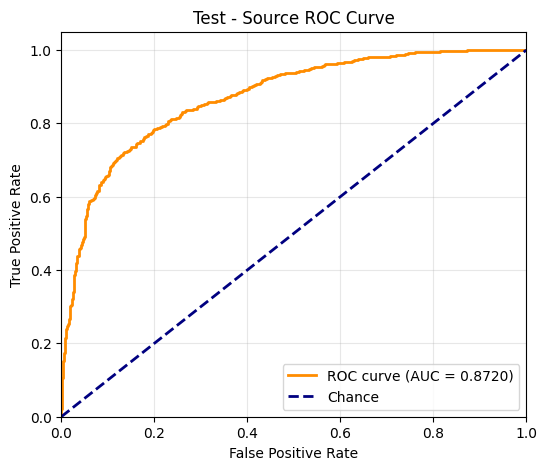

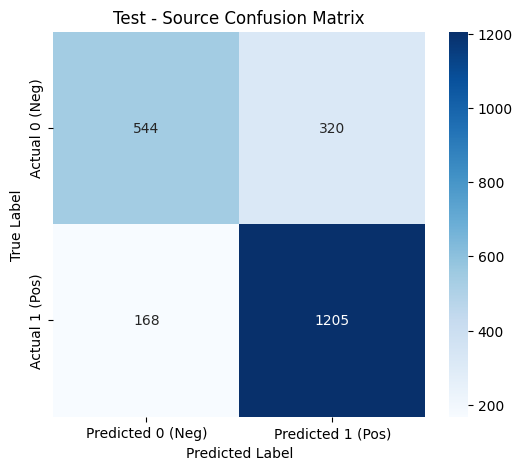


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.7969
Precision (for class 1): 0.7961
Recall (for class 1):    0.9425
F1-Score (for class 1):  0.8632
AUC-ROC:                 0.8326


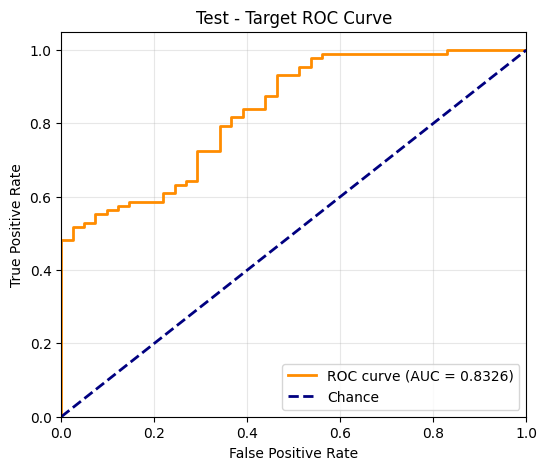

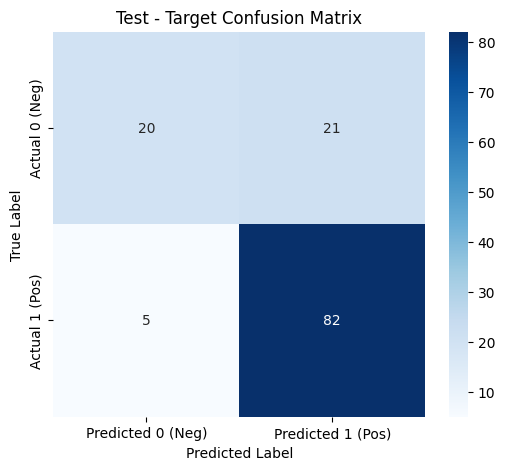

Epoch 6/50: 100%|██████████| 95/95 [00:06<00:00, 13.63it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7895
Precision (for class 1): 0.8072
Recall (for class 1):    0.8631
F1-Score (for class 1):  0.8342
AUC-ROC:                 0.8775


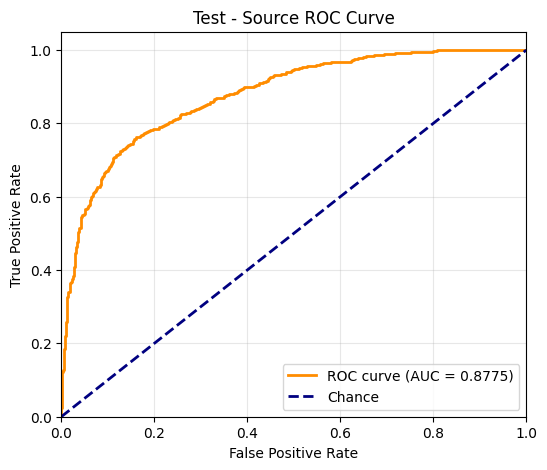

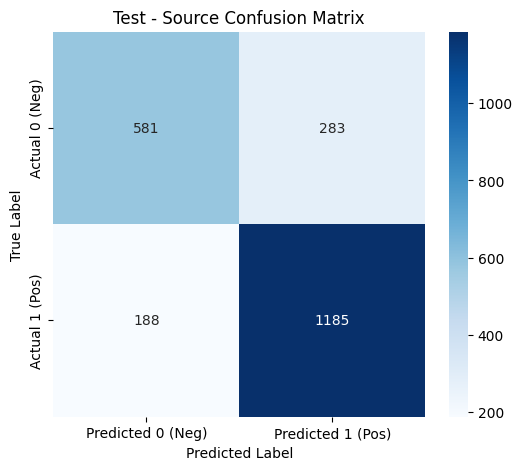


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.8438
Precision (for class 1): 0.8602
Recall (for class 1):    0.9195
F1-Score (for class 1):  0.8889
AUC-ROC:                 0.9022


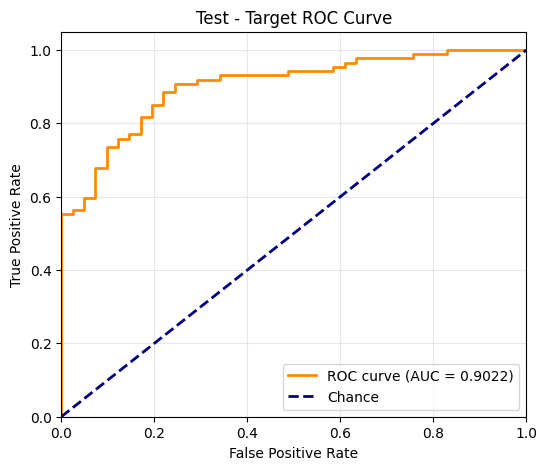

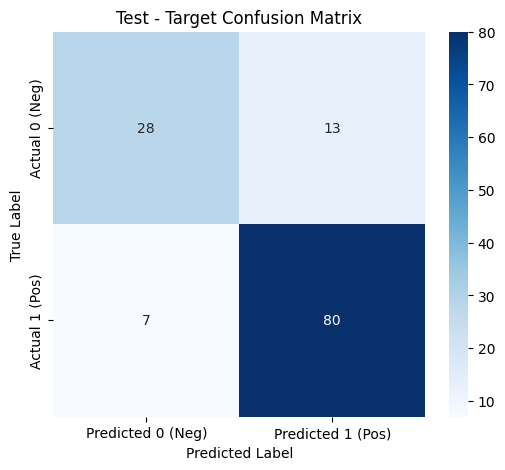

Epoch 11/50: 100%|██████████| 95/95 [00:06<00:00, 13.79it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7832
Precision (for class 1): 0.8203
Recall (for class 1):    0.8281
F1-Score (for class 1):  0.8242
AUC-ROC:                 0.8737


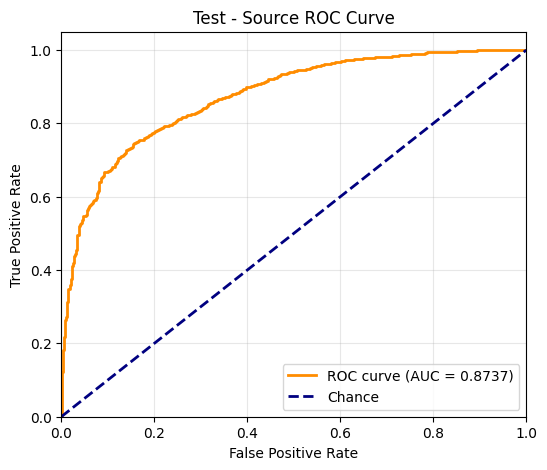

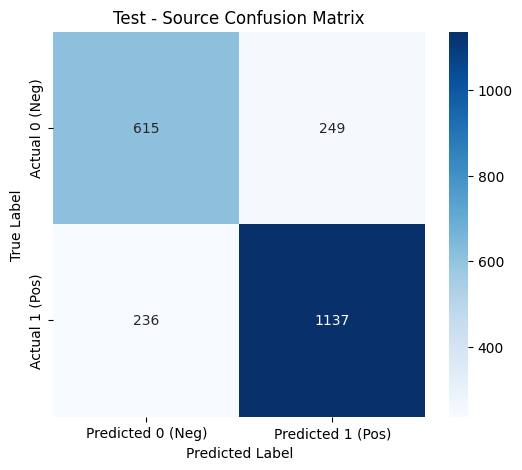


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.8438
Precision (for class 1): 0.8526
Recall (for class 1):    0.9310
F1-Score (for class 1):  0.8901
AUC-ROC:                 0.8567


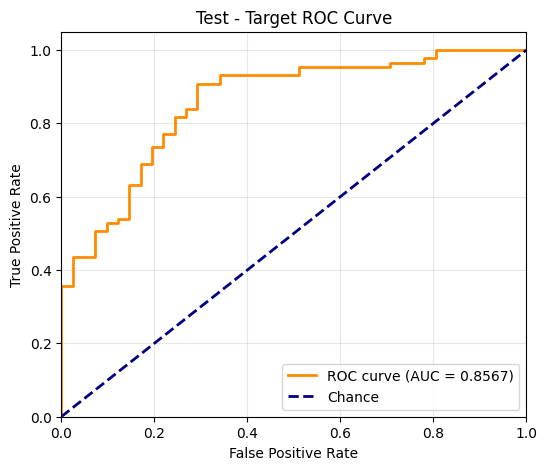

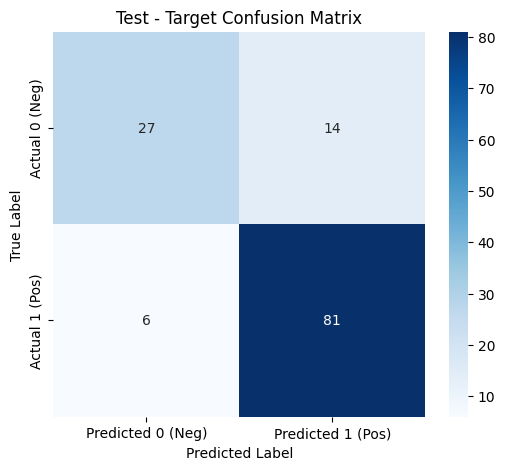

Epoch 16/50: 100%|██████████| 95/95 [00:06<00:00, 13.71it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7886
Precision (for class 1): 0.8008
Recall (for class 1):    0.8725
F1-Score (for class 1):  0.8351
AUC-ROC:                 0.8708


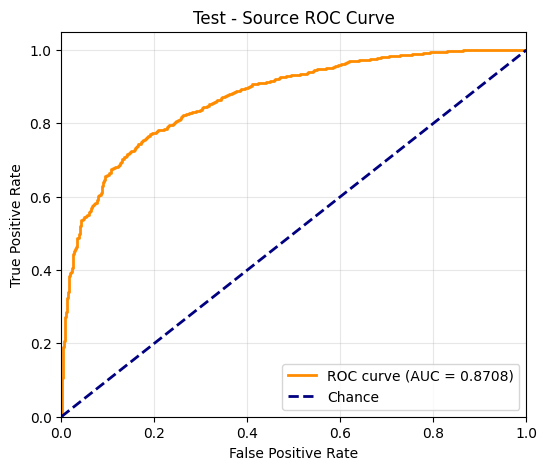

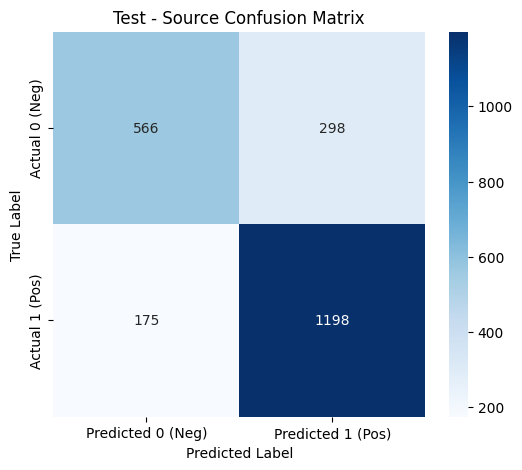


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.8359
Precision (for class 1): 0.8587
Recall (for class 1):    0.9080
F1-Score (for class 1):  0.8827
AUC-ROC:                 0.8514


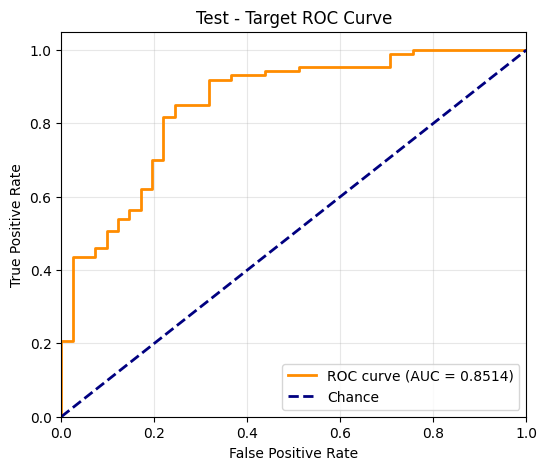

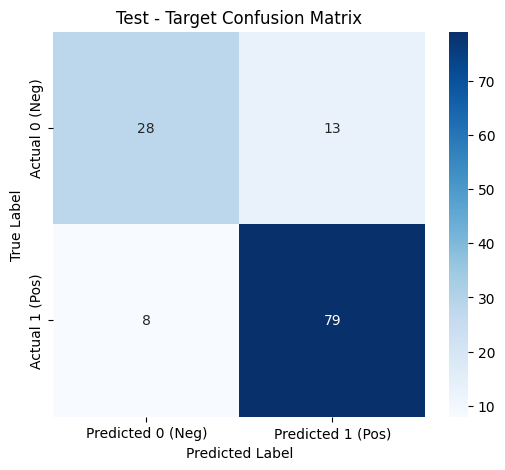

Epoch 21/50: 100%|██████████| 95/95 [00:06<00:00, 13.74it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7734
Precision (for class 1): 0.7631
Recall (for class 1):    0.9148
F1-Score (for class 1):  0.8321
AUC-ROC:                 0.8630


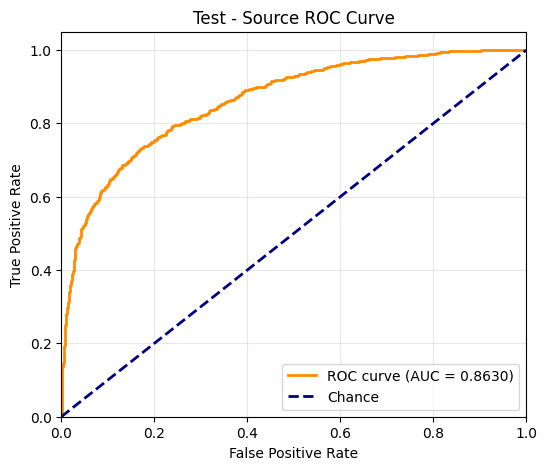

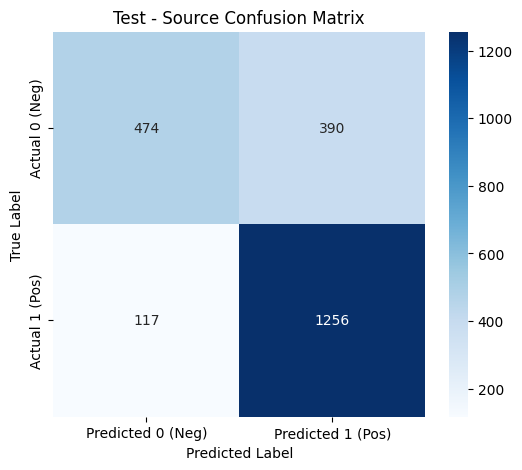


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.7344
Precision (for class 1): 0.8955
Recall (for class 1):    0.6897
F1-Score (for class 1):  0.7792
AUC-ROC:                 0.8682


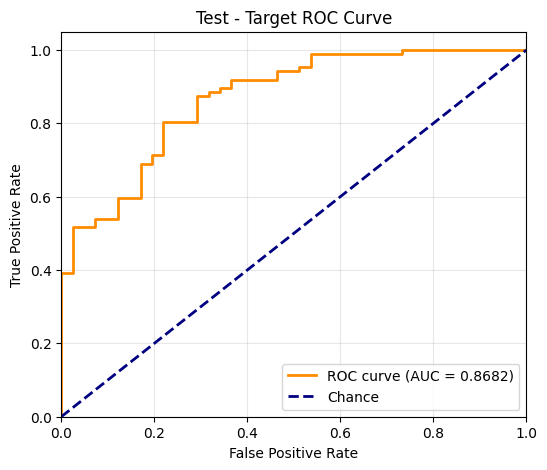

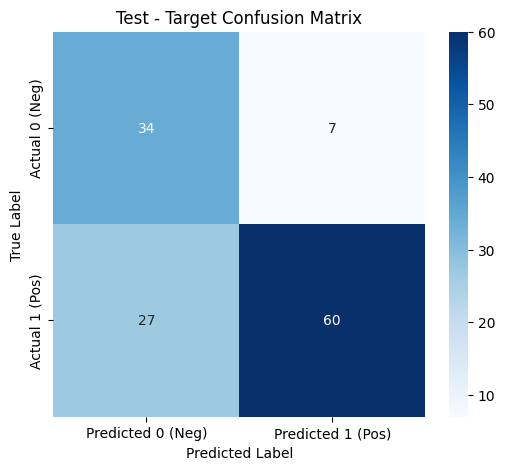

Epoch 26/50: 100%|██████████| 95/95 [00:06<00:00, 13.75it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7738
Precision (for class 1): 0.8195
Recall (for class 1):    0.8099
F1-Score (for class 1):  0.8147
AUC-ROC:                 0.8542


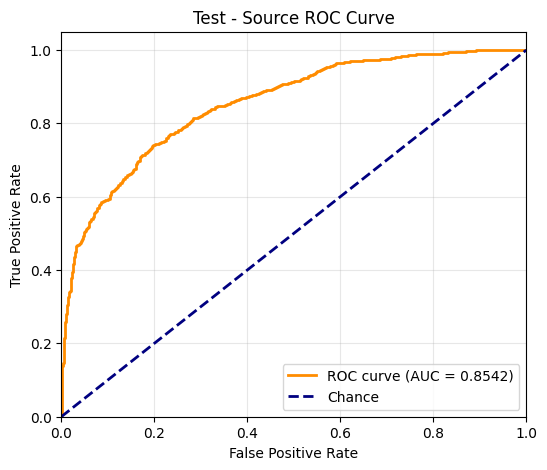

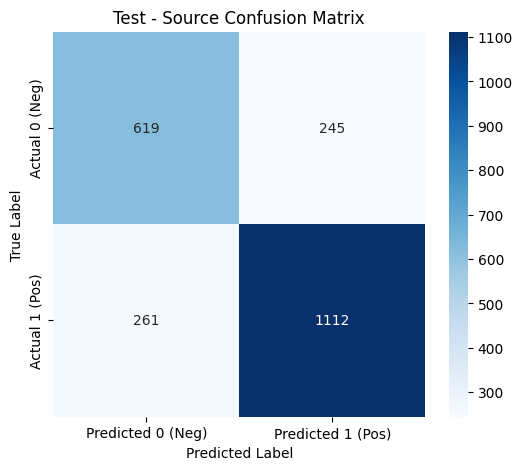


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.6250
Precision (for class 1): 0.9149
Recall (for class 1):    0.4943
F1-Score (for class 1):  0.6418
AUC-ROC:                 0.8438


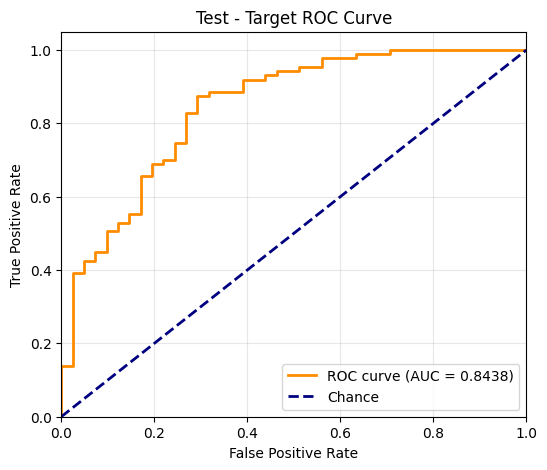

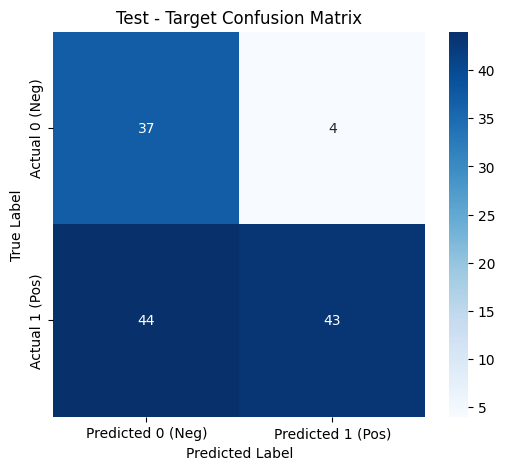

Epoch 31/50: 100%|██████████| 95/95 [00:06<00:00, 13.73it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7573
Precision (for class 1): 0.7677
Recall (for class 1):    0.8667
F1-Score (for class 1):  0.8142
AUC-ROC:                 0.8344


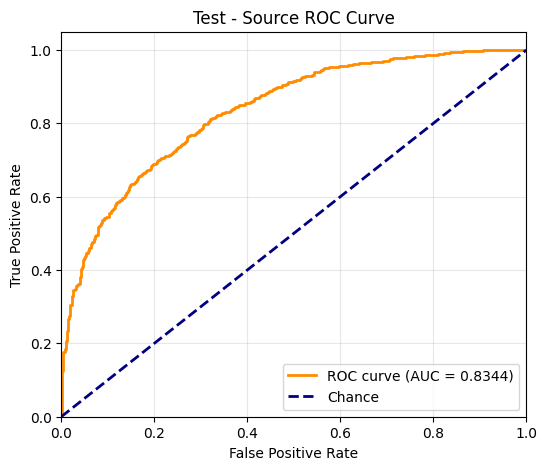

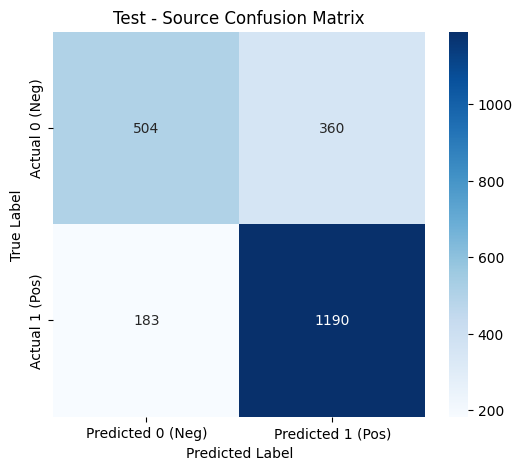


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.6641
Precision (for class 1): 0.9400
Recall (for class 1):    0.5402
F1-Score (for class 1):  0.6861
AUC-ROC:                 0.8705


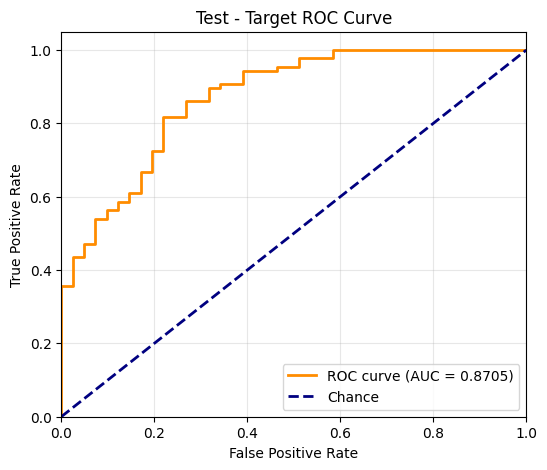

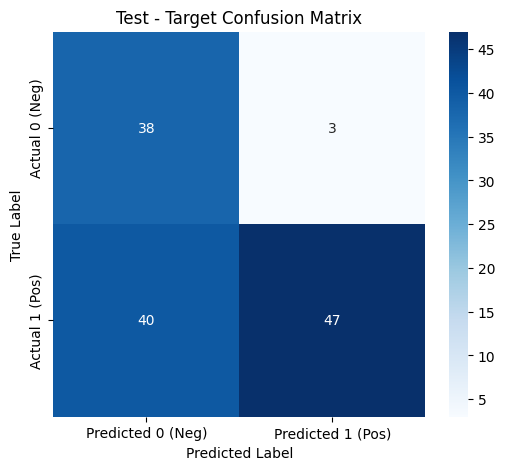

Epoch 36/50: 100%|██████████| 95/95 [00:06<00:00, 13.76it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7577
Precision (for class 1): 0.7768
Recall (for class 1):    0.8492
F1-Score (for class 1):  0.8114
AUC-ROC:                 0.8313


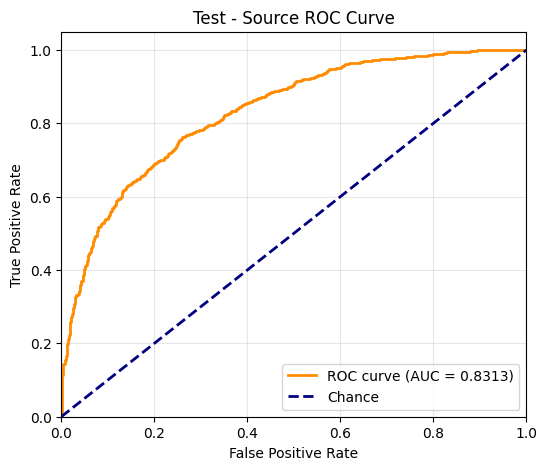

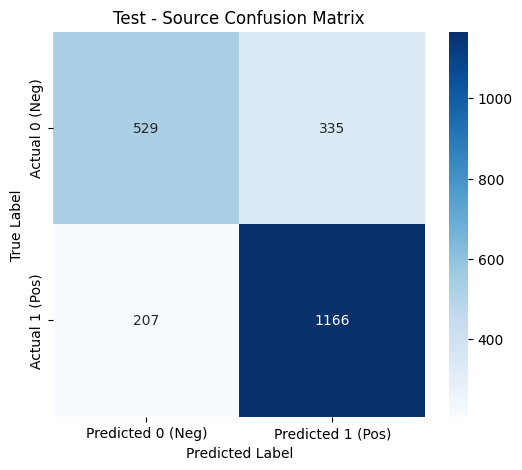


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.6641
Precision (for class 1): 0.8929
Recall (for class 1):    0.5747
F1-Score (for class 1):  0.6993
AUC-ROC:                 0.8203


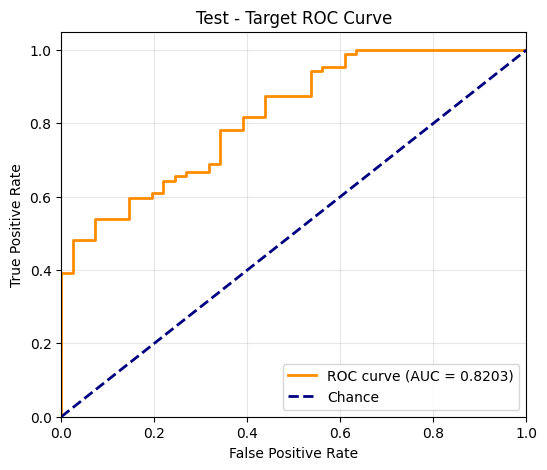

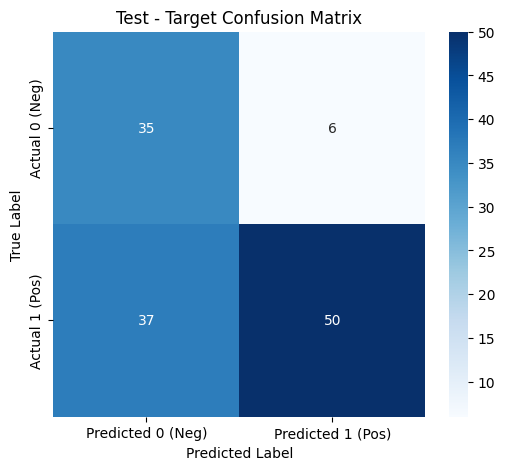

Epoch 41/50: 100%|██████████| 95/95 [00:06<00:00, 13.76it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7702
Precision (for class 1): 0.8193
Recall (for class 1):    0.8026
F1-Score (for class 1):  0.8109
AUC-ROC:                 0.8455


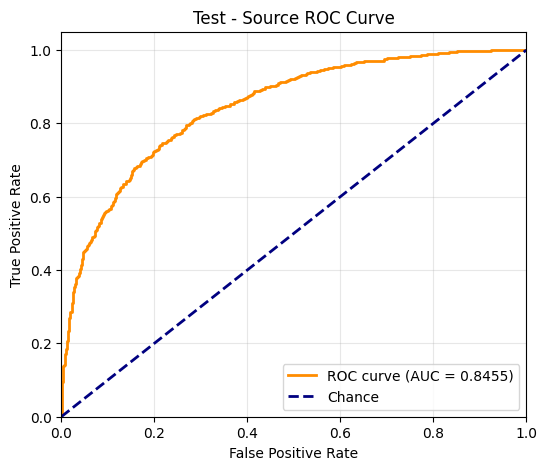

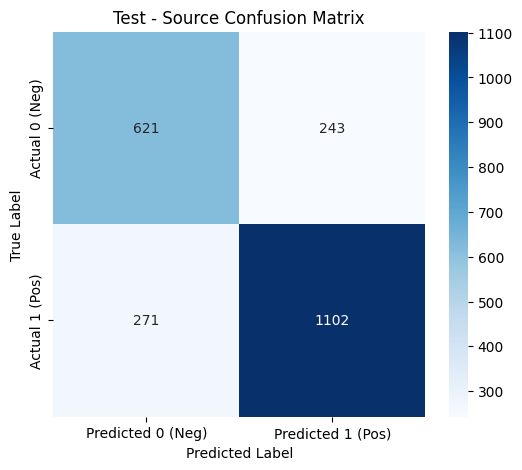


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.6797
Precision (for class 1): 0.9107
Recall (for class 1):    0.5862
F1-Score (for class 1):  0.7133
AUC-ROC:                 0.8441


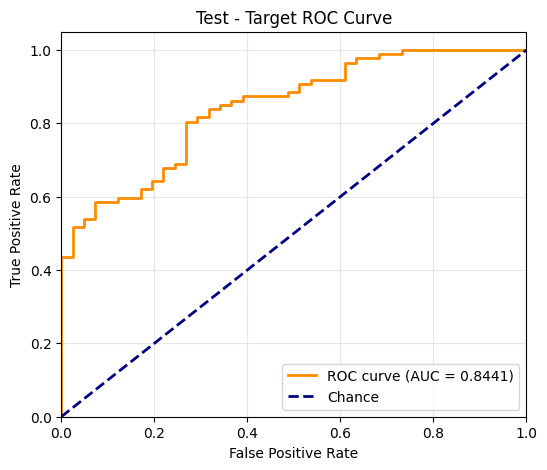

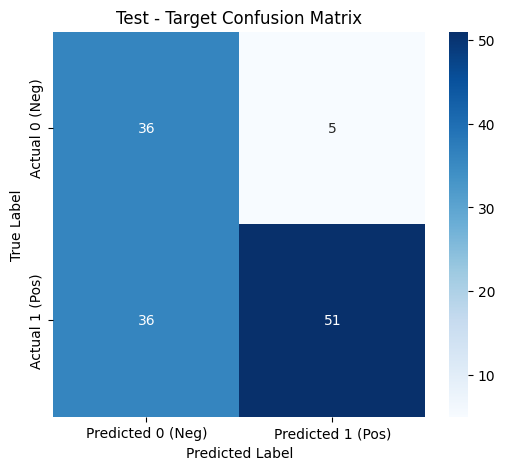

Epoch 46/50: 100%|██████████| 95/95 [00:06<00:00, 13.78it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7327
Precision (for class 1): 0.7903
Recall (for class 1):    0.7684
F1-Score (for class 1):  0.7792
AUC-ROC:                 0.8135


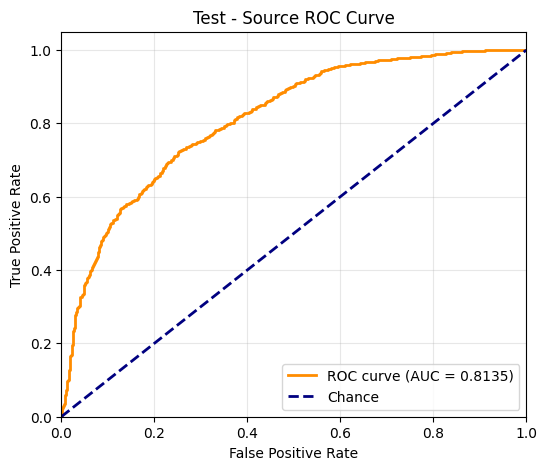

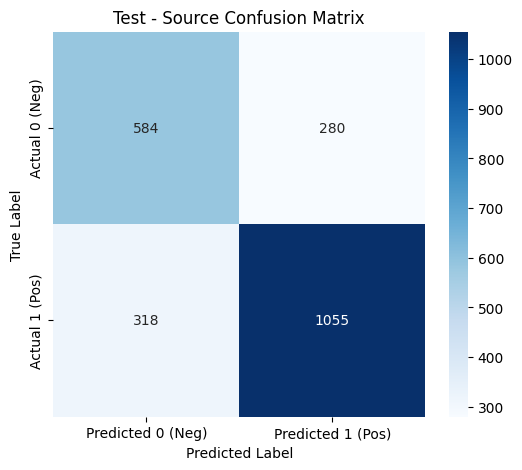


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.6875
Precision (for class 1): 0.9273
Recall (for class 1):    0.5862
F1-Score (for class 1):  0.7183
AUC-ROC:                 0.8548


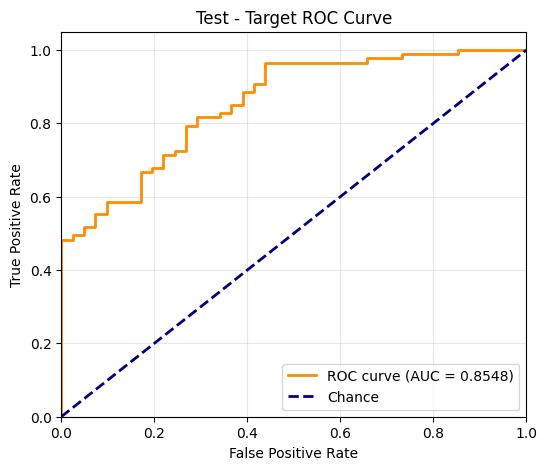

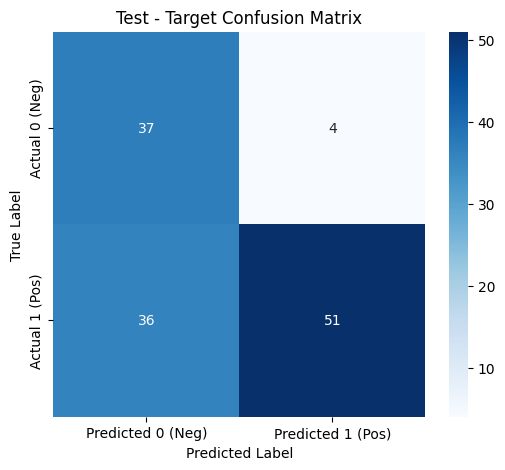

Epoch 50/50: 100%|██████████| 95/95 [00:06<00:00, 13.80it/s]



--- Evaluating: Source Domain ---
Loading data from: test0_clip.csv

** Test Metrics for Source Domain **
Accuracy:                0.7416
Precision (for class 1): 0.8041
Recall (for class 1):    0.7655
F1-Score (for class 1):  0.7843
AUC-ROC:                 0.8122


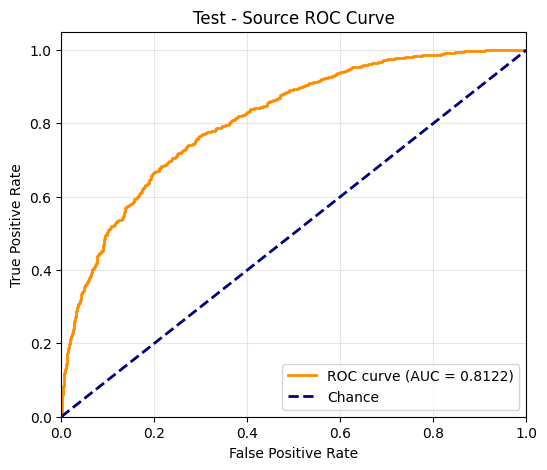

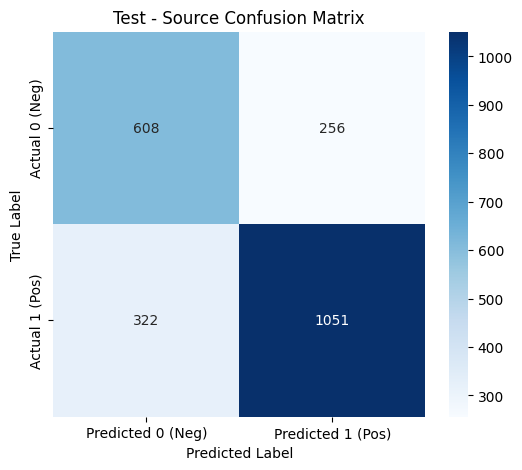


--- Evaluating: Target Domain ---
Loading data from: bluesky_test0.csv

** Test Metrics for Target Domain **
Accuracy:                0.6719
Precision (for class 1): 0.9091
Recall (for class 1):    0.5747
F1-Score (for class 1):  0.7042
AUC-ROC:                 0.8267


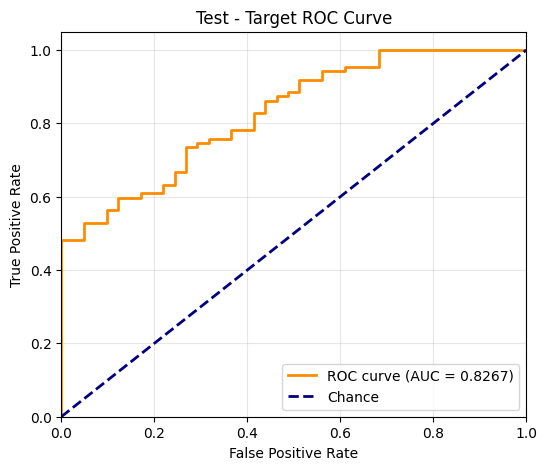

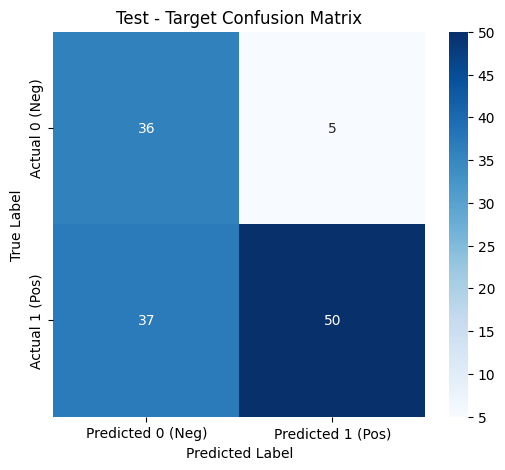

In [12]:
if __name__ == '__main__':
     num_classes = 2
    #  source_event_name = "hurricane_harvey"
    #  target_event_name = "hurricane_irma"

     source_path = "train_clip0.csv"
     target_path = "bluesky_clip.csv"

     size = 768
     model = DomainAdaptation(source_path, target_path, num_classes=num_classes, size=size, batch_size=128, epochs=50)
     #model = DomainAdaptation(source_event_name, target_event_name , num_classes=num_classes, size=size, batch_size=128, epochs=100, csv_path="train_clip0.csv")
     model.train()